# Pierwszy i drugi milestone projektu 2. z przedmiotu WUM
### Alicja Charuza, Mateusz Gałęziewski

Poniżej przedstawiamy naszą pracę związaną z preprocessingiem danych oraz tworzeniem modeli uczenia nienadzorowanego na podstawie [zbioru danych na temat chorób serca](https://www.kaggle.com/datasets/kingabzpro/heart-disease-patients?select=heart_disease_patients.csv).

In [52]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage as scipy_linkage
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

Klasa do preprocessingu:

In [31]:
class Data_Processor:

    def __init__(self):
        self.train_data = None
        self.test_data = None
        self.val_data = None

    def load_split(self, file_path):
        df = pd.read_csv(file_path)
        train_data, val_data = train_test_split(df, test_size=0.3, random_state=42)
        train_data, test_data = train_test_split(train_data, test_size=0.3, random_state=42)
        train_data.reset_index(inplace=True, drop=True)
        test_data.reset_index(inplace=True, drop=True)
        val_data.reset_index(inplace=True, drop=True)
        train_data = train_data.drop(['id'], axis=1)
        test_data = test_data.drop(['id'], axis=1)
        val_data = val_data.drop(['id'], axis=1)
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data
        
#   zdecydowaliśmy się odrzucić pomysł encodingu, gdyż znacznie pogarsza wyniki modelu
    def encode_data(self):
        enc = OneHotEncoder()
        enc_train_data = pd.DataFrame(enc.fit_transform(self.train_data[['cp', 'restecg', 'slope']]).toarray())
        enc_test_data = pd.DataFrame(enc.transform(self.test_data[['cp', 'restecg', 'slope']]).toarray())
        enc_val_data = pd.DataFrame(enc.transform(self.val_data[['cp', 'restecg', 'slope']]).toarray())
        encoded_column_names = enc.get_feature_names_out(['cp', 'restecg', 'slope'])
        enc_train_data.columns = encoded_column_names
        enc_test_data.columns = encoded_column_names
        enc_val_data.columns = encoded_column_names
        self.train_data = (self.train_data.drop(['cp', 'restecg', 'slope'], axis=1)).join(enc_train_data)
        self.test_data = (self.test_data.drop(['cp', 'restecg', 'slope'], axis=1)).join(enc_test_data)
        self.val_data = (self.val_data.drop(['cp', 'restecg', 'slope'], axis=1)).join(enc_val_data)
    
    def normalize_data(self):
        normalize = MinMaxScaler()
        norm_train = normalize.fit_transform(self.train_data)
        norm_test = normalize.transform(self.test_data)
        norm_val = normalize.transform(self.val_data)
        self.train_data = pd.DataFrame(norm_train, columns=self.train_data.columns)
        self.test_data = pd.DataFrame(norm_test, columns=self.test_data.columns)
        self.val_data = pd.DataFrame(norm_val, columns=self.val_data.columns)

    def get_train_data(self):
        return self.train_data
    
    def get_test_data(self):
        return self.test_data
    
    def get_val_data(self):
        return self.val_data

Funkcje do wizualizacji za pomocą T-SNE i PCA:

In [56]:
def t_sne(X, perplexity, pred):
    tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=perplexity).fit_transform(X)
    df1 = pd.DataFrame()
    df1['y'] = pred
    df1["comp-1"] = tsne[:,0]
    df1["comp-2"] = tsne[:,1]
    sns.scatterplot(x="comp-1", y="comp-2", hue=df1.y.tolist(),
            palette=sns.color_palette("hls", 10),
            data=df1)
    

In [65]:
def pca_plt(X, pred):
    pca = PCA(n_components=2).fit_transform(X)
    df1 = pd.DataFrame()
    
    df1['y'] = pred
    df1["comp-1"] = pca[:,0]
    df1["comp-2"] = pca[:,1]
    sns.scatterplot(x="comp-1", y="comp-2", hue=df1.y.tolist(),
            palette=sns.color_palette("hls", 10),
            data=df1)
    

## Preprocessing

In [33]:
dp = Data_Processor()
dp.load_split('data/heart_disease_patients.csv')
X_train = dp.get_train_data()
X_test = dp.get_test_data()

In [4]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,54,1,3,120,258,0,2,147,0,0.4,2
1,58,1,4,125,300,0,2,171,0,0.0,1
2,58,1,4,128,216,0,2,131,1,2.2,2
3,67,1,3,152,212,0,2,150,0,0.8,2
4,56,1,2,130,221,0,2,163,0,0.0,1


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       148 non-null    int64  
 1   sex       148 non-null    int64  
 2   cp        148 non-null    int64  
 3   trestbps  148 non-null    int64  
 4   chol      148 non-null    int64  
 5   fbs       148 non-null    int64  
 6   restecg   148 non-null    int64  
 7   thalach   148 non-null    int64  
 8   exang     148 non-null    int64  
 9   oldpeak   148 non-null    float64
 10  slope     148 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 12.8 KB


In [8]:
X_train.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
dtype: int64

Czyli nie mamy żadnych wierszy z brakami danych.

### Wyjaśnienie kolumn
|kolumna|opis|typ|
|:-:|:--|:-:|
|id|indeks|numeryczny|
|age|wiek|numeryczny|
|sex|płeć|kategoryczny|
|cp|typ bólu klatki piersiowej|kategoryczny|
|trestbps|ciśnienie krwi w spoczynku (w momencie przyjęcia do szpitala) w mm/Hg|numeryczny|
|chol|poziom cholesterolu w surowicy w mg/dl|numeryczny|
|fbs|poziom cukru na czczo w mg/dl > 120 (1 = true, 0 = false)|kategoryczny|
|restecg|wyniki ekg w spoczynku|kategoryczny|
|thalach|maksymalne tętno|numeryczny|
|exang|dławica wysiłkowa (1 = true, 0 = false)|kategoryczny|
|oldpeak|obniżenie odcinka ST wywołane wysiłkiem w porównaniu do spoczynku|numeryczny|
|slope|spadek odcinka ST podczas szczytowego wysiłku|kategoryczny|

### Wyjaśnienie jednostek
|jednostka|opis|
|:-:|:-:|
|mm/Hg|milimetry słupa rtęci|
|mg/dl|miligramy na decylitr|

Spójrzmy, jak wyglądają podstawowe statystyki zmiennych.

In [9]:
X_train.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,54.297297,0.628378,3.101351,130.912162,243.364865,0.121622,0.898649,150.513514,0.324324,0.977027,1.560811
std,9.336097,0.484879,0.987954,18.468922,47.541625,0.327958,0.994816,22.629367,0.469711,1.202554,0.619703
min,34.000000,0.000000,1.000000,94.000000,149.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000
25%,46.000000,0.000000,2.000000,120.000000,208.750000,0.000000,0.000000,133.750000,0.000000,0.000000,1.000000
50%,55.000000,1.000000,3.000000,128.500000,236.500000,0.000000,0.000000,155.000000,0.000000,0.550000,1.000000
75%,62.000000,1.000000,4.000000,140.000000,270.250000,0.000000,2.000000,168.000000,1.000000,1.525000,2.000000
max,76.000000,1.000000,4.000000,200.000000,407.000000,1.000000,2.000000,194.000000,1.000000,6.200000,3.000000


Zwizualizujmy to.

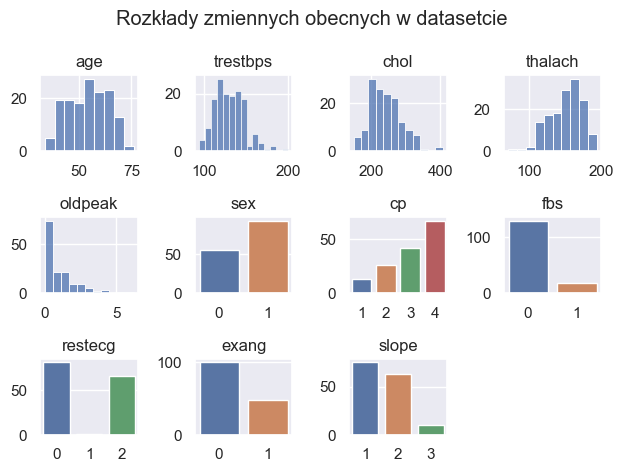

In [10]:
sns.set(style="darkgrid")
f, axes = plt.subplots(nrows=3, ncols=4)

i = 0
for column in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
    x, y = i//4, i%4 
    sns.histplot(x=column, data=X_train, ax=axes[x, y])
    axes[x,y].set_title(column)
    axes[x,y].set_xlabel('')
    axes[x,y].set_ylabel('')
    i += 1

for column in ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope']:
    x, y = i//4, i%4 
    sns.countplot(x=column, data=X_train, ax=axes[x, y])
    axes[x,y].set_title(column)
    axes[x,y].set_xlabel('')
    axes[x,y].set_ylabel('')
    i += 1

f.delaxes(axes[i//4, i%4])
f.suptitle('Rozkłady zmiennych obecnych w datasetcie')

plt.tight_layout()

Możemy zauważyć, że w przypadku zmiennych ciągłych wszystkie prócz 'oldpeak' mają rozkład przybliżony do normalnego.

Zobaczmy jak silne są zależności pomiędzy zmiennymi ciągłymi.

<Axes: >

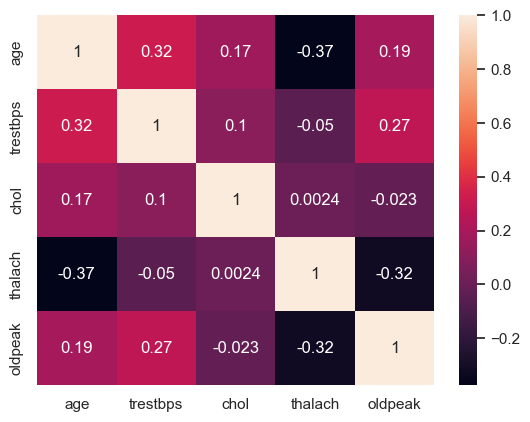

In [11]:
corr_matrix1 = X_train[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].corr(method='pearson')
sns.heatmap(corr_matrix1, annot=True)

Korelacje pomiędzy zmiennymi są na tyle niskie, że decydujemy się nie usuwać kolumn.

Przeprowadzamy normalizację danych.

In [34]:
dp.normalize_data()
X_train = dp.get_train_data()
X_test = dp.get_test_data()

Nie przeprowadzamy encodingu danych kategorycznych, ze względu na znacznie gorsze wyniki modeli. Aby to pokazać zapiszemy dodatkową wersję z encodingiem.

In [35]:
dp2 = Data_Processor()
dp2.load_split('data/heart_disease_patients.csv')
dp2.encode_data()
dp2.normalize_data()
X_train2 = dp2.get_train_data()
X_test2 = dp2.get_test_data()

Zobaczmy jeszcze na koniec, jak wyglądają nasze dane zredukowane do dwóch wymiarów.

Text(0.5, 1.0, 'PCA')

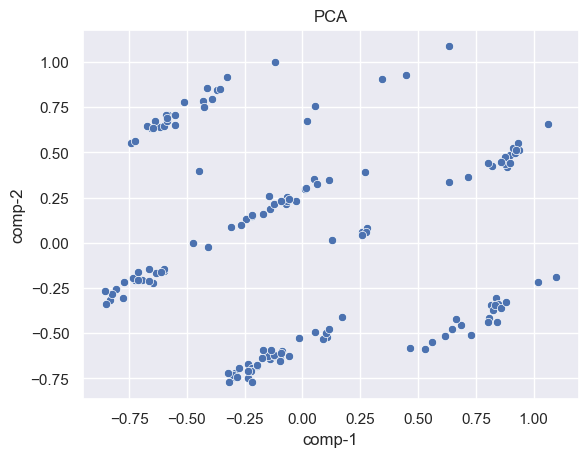

In [14]:
pca = PCA(n_components=2).fit_transform(X_train)
df1 = pd.DataFrame()
df1["comp-1"] = pca[:,0]
df1["comp-2"] = pca[:,1]
sns.scatterplot(x="comp-1", y="comp-2",
        data=df1)
plt.title('PCA')

Na pierwszy rzut oka widzimy 5 klastrów.

Text(0.5, 1.0, 'T-SNE')

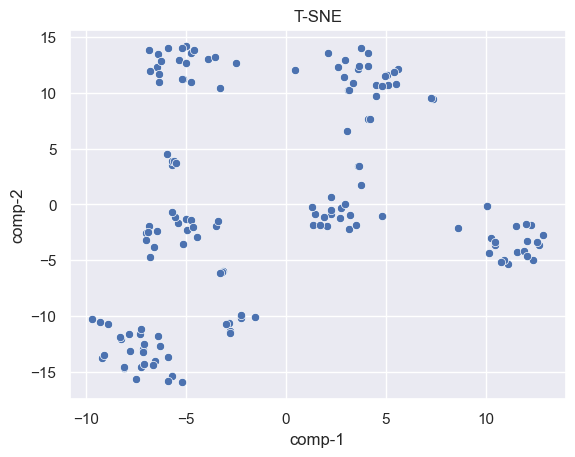

In [15]:
tsne = TSNE(n_components=2, perplexity=20).fit_transform(X_train)
df1 = pd.DataFrame()
df1["comp-1"] = tsne[:,0]
df1["comp-2"] = tsne[:,1]
sns.scatterplot(x="comp-1", y="comp-2",
        data=df1)
plt.title('T-SNE')

Tutaj natomiast formuje nam się około 6 klastrów.

### Teraz zobaczymy jak wyglądają dane z kolumnami kategorycznymi, które zostały poddane encodingowi stosując redukcję wymiarowości


### PCA

Text(0.5, 1.0, 'PCA v2')

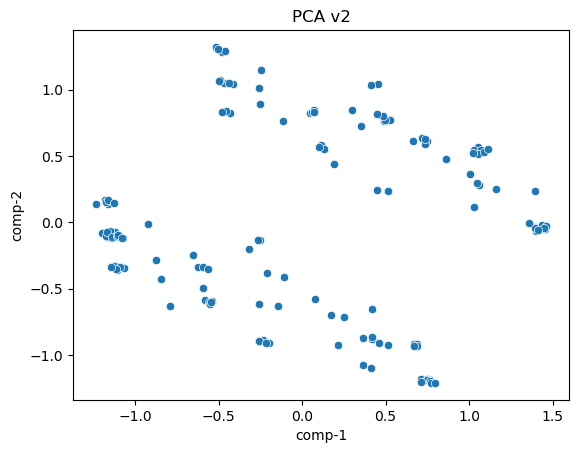

In [15]:
pca2 = PCA(n_components=2).fit_transform(X_train2)
df2 = pd.DataFrame()
df2["comp-1"] = pca2[:,0]
df2["comp-2"] = pca2[:,1]
sns.scatterplot(x="comp-1", y="comp-2",
        data=df2)
plt.title('PCA v2')


### t-SNE

Text(0.5, 1.0, 'T-SNE v2')

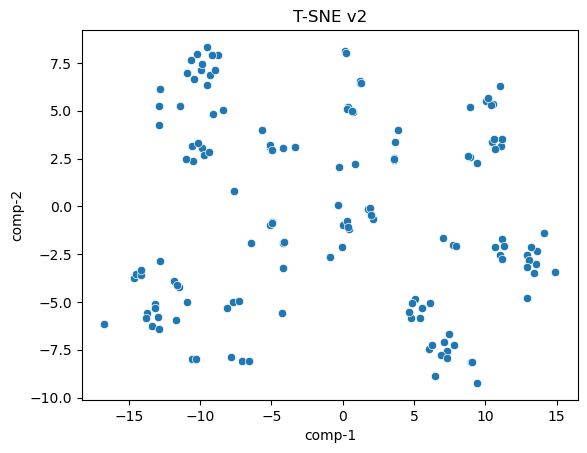

In [16]:
tsne2 = TSNE(n_components=2, perplexity=20).fit_transform(X_train2)
df2 = pd.DataFrame()
df2["comp-1"] = tsne2[:,0]
df2["comp-2"] = tsne2[:,1]
sns.scatterplot(x="comp-1", y="comp-2",
        data=df2)
plt.title('T-SNE v2')

Po zastosowaniu redukcji wymiarowości na danych zawierających kolumny encodowane możemy zauważyć rozproszenie się punktów danych. W porówananiu do danych bez kolumn encodowanych rozpoznanie klastrów nie jest już takie łatwe. Jest widoczna większa ilość tzw. szumu. Grupowanie danych w tym przypadku jest znacznie utrudnione przez przyznanie większej wagi zmiennym encodowanym, co jak się okazuje przeszkadza w grupowaniu pacjentów.Może to skutkować błędnym podjęciem działań przez lekarzy lub podjęcie działań niewystarczających/niedopasowanych na potrzeby danej grupy badanych charakteryzących się podbnymi objawami. Złe dostosowanie środków może kosztować ich życie. Postanowiliśmy więc usunąć kolumny zawierające typ bólu w klatce piersiowej [chest pain type], typ wyników ekg w spoczynku [restecg] oraz spadek odcinka ST podczas szczytowego wysiłku [slope]. Podjęte przez nas kroki będą skutkowały lepszymi wynikami zastosowanych przez nas modeli uczenia nienadzorowanego. 

## Modele

### KMeans

Najpierw za pomocą metod łokcia i analizy silhouette score, spróbujmy wybrać odpowiednią liczbę klastrów dla modelu KMeans.

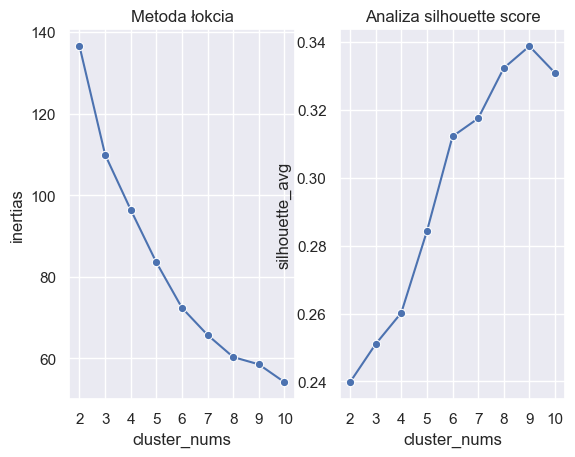

In [18]:
f, axes = plt.subplots(nrows=1, ncols=2)

cluster_nums = range(2, 11)
inertias = []

for num in cluster_nums:
    kmeans = KMeans(n_clusters=num)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)

df = pd.DataFrame()
df['cluster_nums'] = cluster_nums
df['inertias'] = inertias
sns.lineplot(x='cluster_nums', y='inertias', marker='o', data=df, ax=axes[0])
axes[0].set_title('Metoda łokcia')
axes[0].set_xticks(range(2, 11))

silhouette_avg = []
for num in cluster_nums:
    kmeans = KMeans(n_clusters=num)
    kmeans.fit(X_train)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(X_train, cluster_labels))

df['silhouette_avg'] = silhouette_avg
sns.lineplot(x='cluster_nums', y='silhouette_avg', marker='o', data=df, ax=axes[1])
axes[1].set_title('Analiza silhouette score')
axes[1].set_xticks(range(2, 11))

Liczby klastrów, które decydujemy się sprawdzić to 6, 7, 8 i 9.

In [19]:
kmeans6 = KMeans(n_clusters=6)
pred6 = kmeans6.fit_predict(X_train)

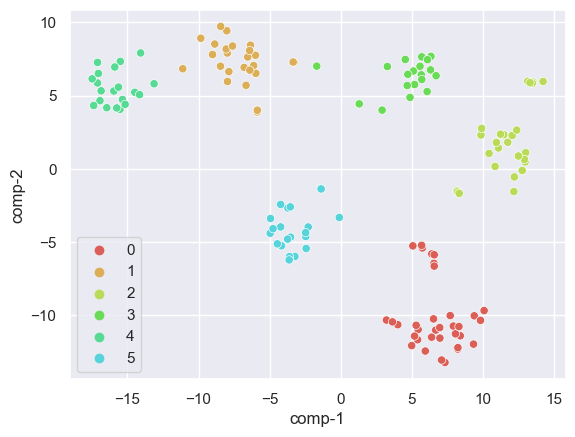

In [20]:
t_sne(X_train, 20, pred6)

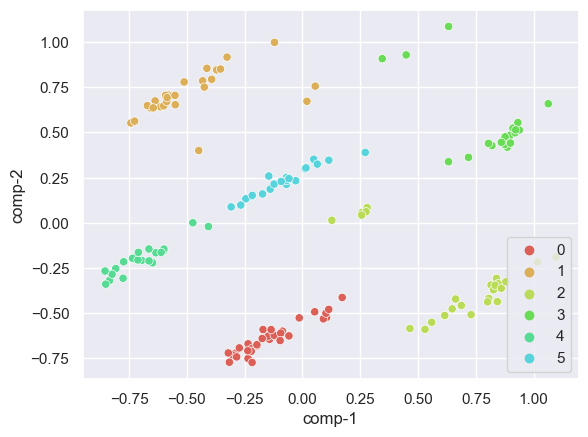

In [21]:
pca_plt(X_train, pred6)

In [22]:
kmeans7 = KMeans(n_clusters=7)
pred7 = kmeans7.fit_predict(X_train)

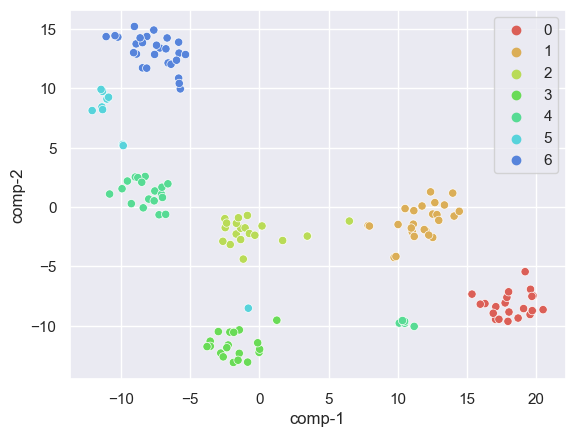

In [23]:
t_sne(X_train, 20, pred7)

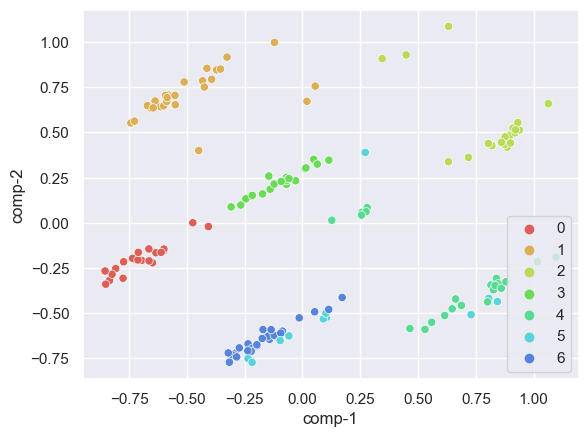

In [24]:
pca_plt(X_train, pred7)

In [25]:
kmeans8 = KMeans(n_clusters=8)
pred8 = kmeans8.fit_predict(X_train)

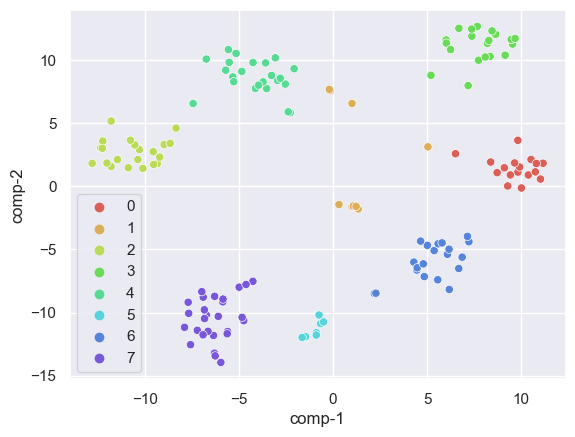

In [26]:
t_sne(X_train, 20, pred8)

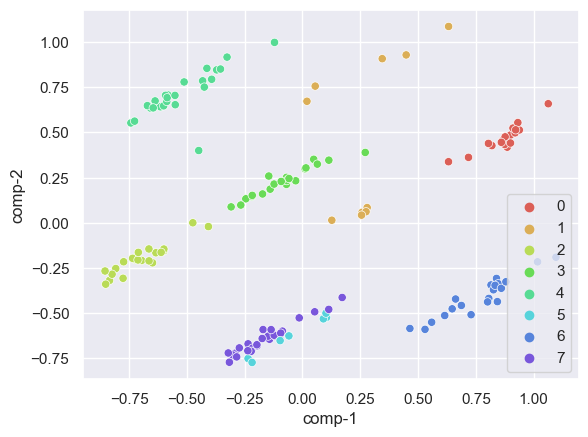

In [27]:
pca_plt(X_train, pred8)

In [28]:
kmeans9 = KMeans(n_clusters=9)
pred9 = kmeans9.fit_predict(X_train)

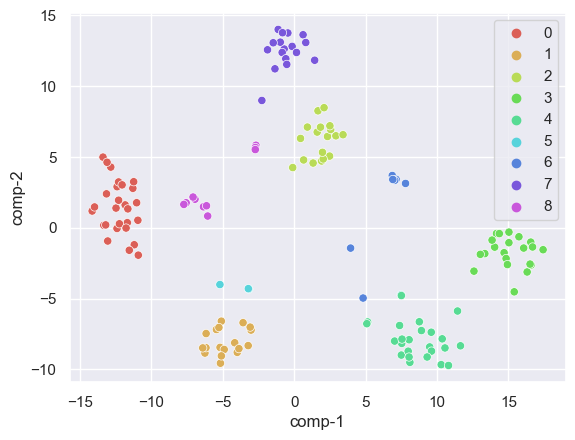

In [29]:
t_sne(X_train, 20, pred9)

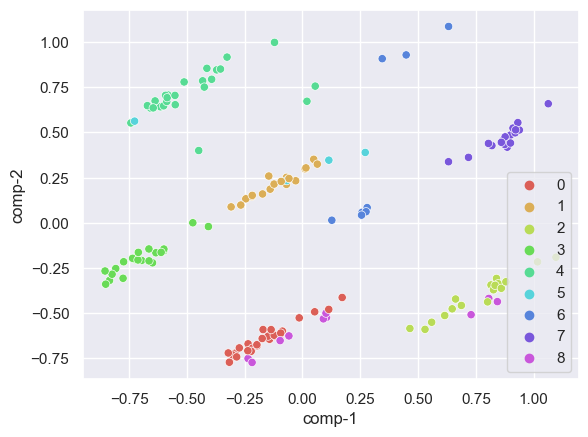

In [30]:
pca_plt(X_train, pred9)

Porównajmy metryki.

In [31]:
data = {'6 klastrów' : [kmeans6.inertia_, silhouette_score(X_train, kmeans6.labels_), np.mean(euclidean_distances(kmeans6.cluster_centers_)),
                        davies_bouldin_score(X_train, pred6), calinski_harabasz_score(X_train, pred6)],
        '7 klastrów' : [kmeans7.inertia_, silhouette_score(X_train, kmeans7.labels_), np.mean(euclidean_distances(kmeans7.cluster_centers_)),
                        davies_bouldin_score(X_train, pred7), calinski_harabasz_score(X_train, pred7)],
        '8 klastrów' : [kmeans8.inertia_, silhouette_score(X_train, kmeans8.labels_), np.mean(euclidean_distances(kmeans8.cluster_centers_)),
                        davies_bouldin_score(X_train, pred8), calinski_harabasz_score(X_train, pred8)],
        '9 klastrów' : [kmeans9.inertia_, silhouette_score(X_train, kmeans9.labels_), np.mean(euclidean_distances(kmeans9.cluster_centers_)),
                        davies_bouldin_score(X_train, pred9), calinski_harabasz_score(X_train, pred9)],
        'Lepsza większa czy mniejsza wartość?' : ['mniejsza', 'większa', 'większa', 'mniejsza', 'większa']}
df = pd.DataFrame(data)
df.index = ['Inertia', 'Silhouette Score', 'Miara odległości między klastrami', 'Davies Bouldin Score', 'Calinski Harabasz Score']
df

,6 klastrów,7 klastrów,8 klastrów,9 klastrów,Lepsza większa czy mniejsza wartość?
Inertia,72.320860,65.853519,60.913625,56.909044,mniejsza
Silhouette Score,0.312183,0.319253,0.333330,0.342372,większa
Miara odległości między klastrami,1.076859,1.133435,1.187138,1.239516,większa
Davies Bouldin Score,1.275706,1.209516,1.200898,1.157860,mniejsza
Calinski Harabasz Score,40.892059,39.467665,37.935433,36.498133,większa


Zastanawiamy się nad wyborem 6 klastrów i 9 klastrów. Mimo, że 9 klastrów ma lepszy wynik w większości metryk, nie możemy zapominać, że są to dane medyczne i naszym głównym celem jest wyznaczenie grup pacjentów o podobnych objawach. Dlatego powinniśmy przyłożyć szczególną uwagę do wartości Calinski-Harabasz, która wskazuje nam jak bardzo podobne są poszczególne obserwacje do swojego klastru, w porównaniu do innych klastrów. Dodatkowo często klastry ponad liczbę 6 zawierają bardzo mało obserwacji. Z tego powodu wydaje nam się, że to zwyczajnie szczególne przypadki - jak wiemy organizmy mogą bardzo się od siebie różnić.

Poniżej są wyniki, jakie uzyskaliśmy korzystając z one-hot encoding.

In [32]:
kmeans6_enc = KMeans(n_clusters=6)
kmeans7_enc = KMeans(n_clusters=7)
kmeans8_enc = KMeans(n_clusters=8)
kmeans9_enc = KMeans(n_clusters=9)

pred6_enc = kmeans6_enc.fit_predict(X_train2)
pred7_enc = kmeans7_enc.fit_predict(X_train2)
pred8_enc = kmeans8_enc.fit_predict(X_train2)
pred9_enc = kmeans9_enc.fit_predict(X_train2)

In [33]:
data = {'6 klastrów' : [kmeans6_enc.inertia_, silhouette_score(X_train2, kmeans6_enc.labels_), np.mean(euclidean_distances(kmeans6_enc.cluster_centers_)),
                        davies_bouldin_score(X_train2, pred6_enc), calinski_harabasz_score(X_train2, pred6_enc)],
        '7 klastrów' : [kmeans7_enc.inertia_, silhouette_score(X_train2, kmeans7_enc.labels_), np.mean(euclidean_distances(kmeans7_enc.cluster_centers_)),
                        davies_bouldin_score(X_train2, pred7_enc), calinski_harabasz_score(X_train2, pred7_enc)],
        '8 klastrów' : [kmeans8_enc.inertia_, silhouette_score(X_train2, kmeans8_enc.labels_), np.mean(euclidean_distances(kmeans8_enc.cluster_centers_)),
                        davies_bouldin_score(X_train2, pred8_enc), calinski_harabasz_score(X_train2, pred8_enc)],
        '9 klastrów' : [kmeans9_enc.inertia_, silhouette_score(X_train2, kmeans9_enc.labels_), np.mean(euclidean_distances(kmeans9_enc.cluster_centers_)),
                        davies_bouldin_score(X_train2, pred9_enc), calinski_harabasz_score(X_train2, pred9_enc)],
        'Lepsza większa czy mniejsza wartość?' : ['mniejsza', 'większa', 'większa', 'mniejsza', 'większa']}
df = pd.DataFrame(data)
df.index = ['Inertia', 'Silhouette Score', 'Miara odległości między klastrami', 'Davies Bouldin Score', 'Calinski Harabasz Score']
df

,6 klastrów,7 klastrów,8 klastrów,9 klastrów,Lepsza większa czy mniejsza wartość?
Inertia,181.805024,164.682766,153.994763,145.540695,mniejsza
Silhouette Score,0.223468,0.254077,0.255836,0.263932,większa
Miara odległości między klastrami,1.437806,1.508247,1.543377,1.597063,większa
Davies Bouldin Score,1.586902,1.478224,1.537760,1.485658,mniejsza
Calinski Harabasz Score,28.897968,28.841537,27.637702,26.414212,większa


Jak widać większość metryk wychodzi gorzej.

### KMedoids

Teraz spróbujmy zastosować KMedoids.

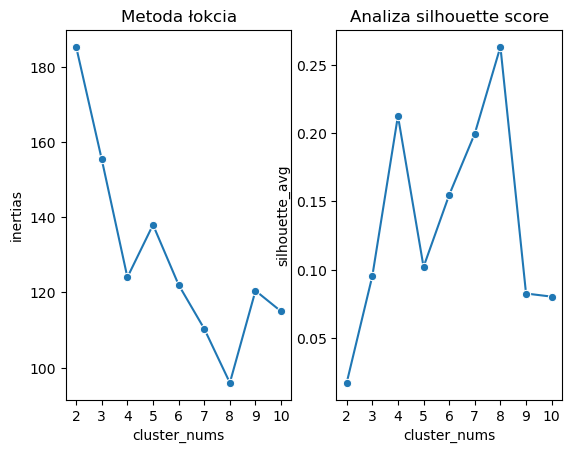

In [53]:
f, axes = plt.subplots(nrows=1, ncols=2)

cluster_nums = range(2, 11)
inertias = []

for num in cluster_nums:
    kmedoids = KMedoids(n_clusters=num)
    kmedoids.fit(X_train)
    inertias.append(kmedoids.inertia_)

df = pd.DataFrame()
df['cluster_nums'] = cluster_nums
df['inertias'] = inertias
sns.lineplot(x='cluster_nums', y='inertias', marker='o', data=df, ax=axes[0])
axes[0].set_title('Metoda łokcia')
axes[0].set_xticks(range(2, 11))

silhouette_avg = []
for num in cluster_nums:
    kmedoids = KMedoids(n_clusters=num)
    kmedoids.fit(X_train)
    cluster_labels = kmedoids.labels_
    silhouette_avg.append(silhouette_score(X_train, cluster_labels))

df['silhouette_avg'] = silhouette_avg
sns.lineplot(x='cluster_nums', y='silhouette_avg', marker='o', data=df, ax=axes[1])
axes[1].set_title('Analiza silhouette score')
axes[1].set_xticks(range(2, 11))

Postanowiliśmy tutaj sprawdzić 6 i 8 klastrów. Zacznijmy od 6.

In [62]:
kmedoids6 = KMedoids(n_clusters=6, random_state=42)
pred6 = kmedoids6.fit_predict(X_train)

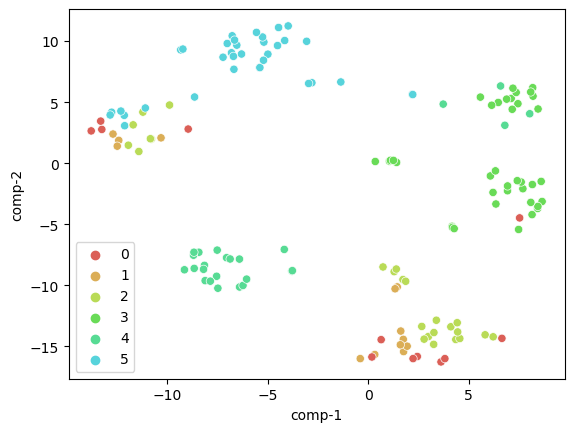

In [63]:
t_sne(X_train, 20, pred6)

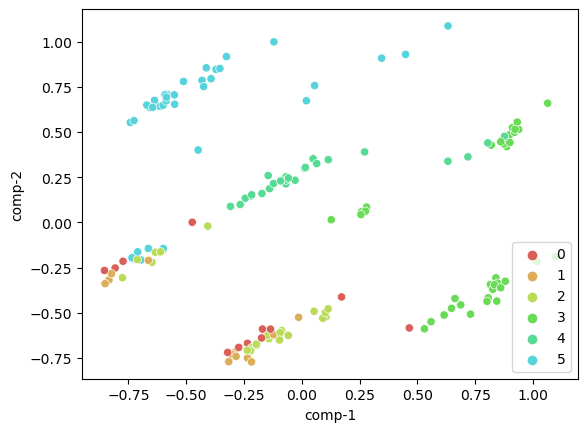

In [66]:
pca_plt(X_train, pred6)

In [67]:
kmedoids8= KMedoids(n_clusters=8, random_state=42)
pred8 = kmedoids8.fit_predict(X_train)

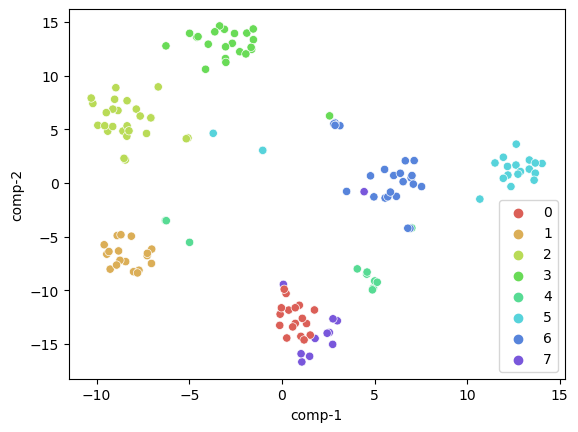

In [68]:
t_sne(X_train, 20, pred8)

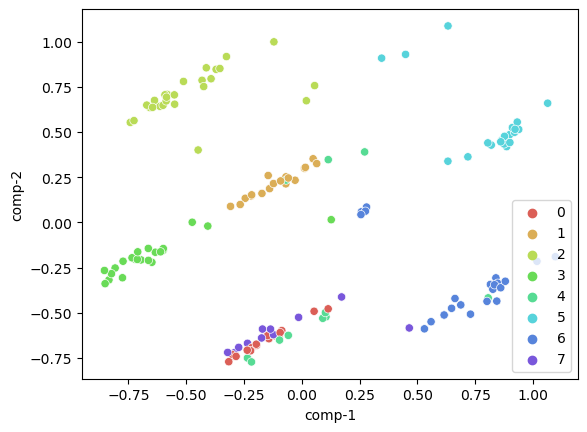

In [69]:
pca_plt(X_train, pred8)

In [70]:
data = {'6 klastrów' : [silhouette_score(X_train, kmedoids6.labels_),
                        davies_bouldin_score(X_train, pred6), calinski_harabasz_score(X_train, pred6)],
        '8 klastrów' : [silhouette_score(X_train, kmedoids8.labels_),
                        davies_bouldin_score(X_train, pred8), calinski_harabasz_score(X_train, pred8)],
        'Lepsza większa czy mniejsza wartość?' : ['większa','mniejsza', 'większa']}
df = pd.DataFrame(data)
df.index = ['Silhouette Score', 'Davies Bouldin Score', 'Calinski Harabasz Score']
df

,6 klastrów,8 klastrów,Lepsza większa czy mniejsza wartość?
Silhouette Score,0.154717,0.263214,większa
Davies Bouldin Score,2.107327,1.444710,mniejsza
Calinski Harabasz Score,23.373532,34.267786,większa


Jak powyżej widzimy, algorytm KMedoids nie działa dobrze. K-means radzi sobie lepiej. Spróbujmy jeszcze innych modeli...

### DBSCAN


Pozwolimy sobie empirycznie dobrać parametry, tak aby otrzymać 6 oraz 9 klastrów oraz minimalizując ilość punktów szumu.

In [67]:
dbs_1 = DBSCAN(min_samples=4, eps=0.6)
test_db1 = dbs_1.fit(X_train)
labels1 = test_db1.labels_

clusters = len(set(labels1)) - (1 if -1 in labels1 else 0)
print('Przewidywana liczba klastrów: %d' % clusters)

noise = list(labels1).count(-1)
print('Przewidywana liczba punktów klasyfikowanych jako szum: %d' % noise)

Przewidywana liczba klastrów: 9
Przewidywana liczba punktów klasyfikowanych jako szum: 35


In [68]:
dbs_2 = DBSCAN(min_samples=7, eps=0.7)
test_db2 = dbs_2.fit(X_train)
labels2 = test_db2.labels_

clusters = len(set(labels2)) - (1 if -1 in labels2 else 0)
print('Przewidywana liczba klastrów: %d' % clusters)

noise = list(labels2).count(-1)
print('Przewidywana liczba punktów klasyfikowanych jako szum: %d' % noise)

Przewidywana liczba klastrów: 6
Przewidywana liczba punktów klasyfikowanych jako szum: 36


Zatem zobaczmy DBSCAN na danych bez kolumn encodowanych.

Najpierw wizualizacje dla 9 klastrów.

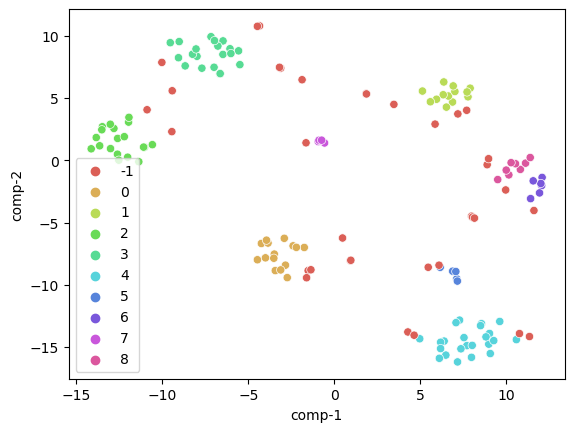

In [69]:
dbs9 = dbs_1.fit_predict(X_train)
t_sne(X_train, 20, dbs9)

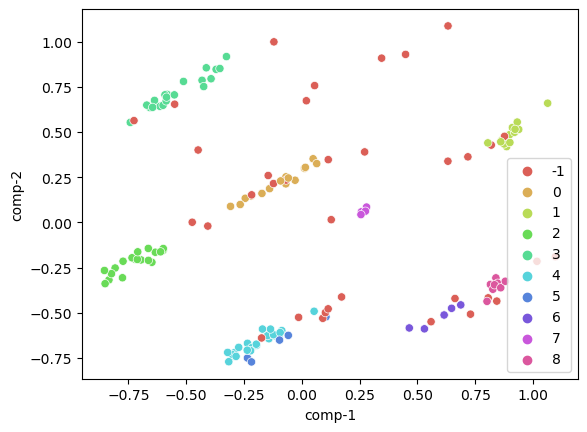

In [70]:
pca_plt(X_train, dbs9)

Wziualizacje dla 6 klastrów.

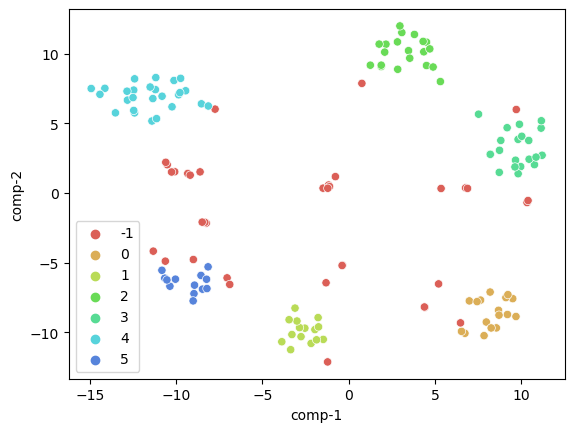

In [65]:
dbs6 = dbs_2.fit_predict(X_train)
t_sne(X_train, 20, dbs6)

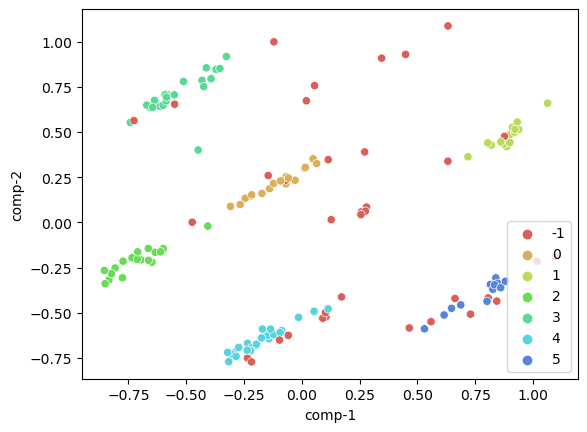

In [71]:
pca_plt(X_train, dbs6)

In [72]:
data = {'6 klastrów' : [silhouette_score(X_train, dbs_2.labels_),
                        davies_bouldin_score(X_train, dbs6), calinski_harabasz_score(X_train, dbs6)],
        '9 klastrów' : [silhouette_score(X_train, dbs_1.labels_),
                        davies_bouldin_score(X_train, dbs9), calinski_harabasz_score(X_train, dbs9)],
        'Lepsza większa czy mniejsza wartość?' : ['większa', 'mniejsza', 'większa']}
df = pd.DataFrame(data)
df.index = ['Silhouette Score', 'Davies Bouldin Score', 'Calinski Harabasz Score']
df

,6 klastrów,9 klastrów,Lepsza większa czy mniejsza wartość?
Silhouette Score,0.260004,0.257902,większa
Davies Bouldin Score,1.579210,1.526470,mniejsza
Calinski Harabasz Score,27.341553,20.601264,większa


Poniżej są wyniki, jakie uzyskaliśmy korzystając z one-hot encoding.

In [60]:
dbs6_enc = dbs_2.fit_predict(X_train2)
dbs9_enc = dbs_1.fit_predict(X_train2)

In [73]:
data = {'6 klastrów' : [silhouette_score(X_train2, dbs_2.labels_),
                        davies_bouldin_score(X_train2, dbs6_enc), calinski_harabasz_score(X_train2, dbs6_enc)],
        '9 klastrów' : [silhouette_score(X_train2, dbs_1.labels_),
                        davies_bouldin_score(X_train2, dbs9_enc), calinski_harabasz_score(X_train2, dbs9_enc)],
        'Lepsza większa czy mniejsza wartość?' : ['większa', 'mniejsza', 'większa']}
df = pd.DataFrame(data)
df.index = ['Silhouette Score', 'Davies Bouldin Score', 'Calinski Harabasz Score']
df

,6 klastrów,9 klastrów,Lepsza większa czy mniejsza wartość?
Silhouette Score,0.105389,0.124852,większa
Davies Bouldin Score,1.281609,1.281609,mniejsza
Calinski Harabasz Score,9.231174,9.231174,większa


Niestety DBSCAN wypada o wiele gorzej od KMeans.

### OPTICS

Zobaczmy jak poradzi sobie 'krewny' DBSCAN na zbiorze bez kolumn encodowanych.

In [155]:
optics = OPTICS()
X_data = X_train

In [156]:
def custom_calinski(estimator, X_data):
    labels = estimator.labels_
    score=calinski_harabasz_score(X_data, labels)
    return score

In [157]:
param_grid = {
    'min_samples': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'metric': ['euclidean', 'manhattan', 'cosine', 'l1', 'l2'],
    'p': [1, 2, 3, 4, 5]
}

rand_search = RandomizedSearchCV(optics, param_grid, scoring=custom_calinski, cv=5, n_iter=10)
rand_search.fit(X_train)
best_params = rand_search.best_params_
print('Najlepsze parametry: ', best_params)

Najlepsze parametry:  {'p': 4, 'min_samples': 10, 'metric': 'l2'}


In [160]:
optics_param = OPTICS(min_samples=best_params['min_samples'], metric=best_params['metric'], p=best_params['p'])
test_opt = optics_param.fit(X_train)
labels = test_opt.labels_

clusters = len(set(labels)) - (1 if -1 in labels else 0)
print('Przewidywana liczba klastrów: %d' % clusters)

noise = list(labels).count(-1)
print('Przewidywana liczba punktów klasyfikowanych jako szum: %d' % noise)

Przewidywana liczba klastrów: 6
Przewidywana liczba punktów klasyfikowanych jako szum: 30


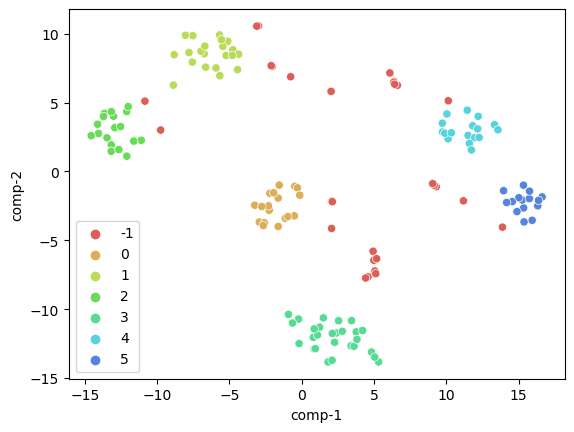

In [159]:
opt=optics_param.fit_predict(X_train)
t_sne(X_train, 20, opt)

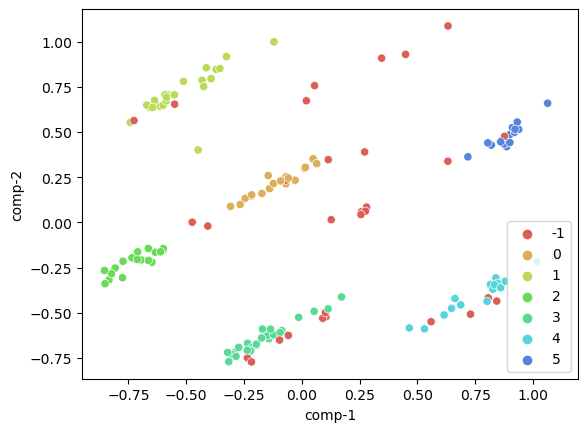

In [161]:
pca_plt(X_train, opt)

In [166]:
data = {'6 klastrów' : [silhouette_score(X_train, optics_param.labels_),
                        davies_bouldin_score(X_train, opt), calinski_harabasz_score(X_train, opt)],
        'Lepsza większa czy mniejsza wartość?' : ['większa', 'mniejsza', 'większa']}
df = pd.DataFrame(data)
df.index = ['Silhouette Score','Davies Bouldin Score', 'Calinski Harabasz Score']
df

,6 klastrów,Lepsza większa czy mniejsza wartość?
Silhouette Score,0.281854,większa
Davies Bouldin Score,1.543781,mniejsza
Calinski Harabasz Score,30.475718,większa


In [169]:
X_train.shape


(148, 11)

OPTICS poradził sobie lepiej niż DBSCAN, ale ciągle najlepszy jest KMeans. Zaletą takich modeli jak OPTICS czy DBSCAN jest wykrywanie szumu. W praktyce oznacza to, większość pacjntów możemy sklasyfikować w grupy, gdzie każda z nich poddawana była automatycznie odpowiedniemu leczeniu czy dalszej diagnozie. Pacjenci nieprzypisani do żadnej z nich, czyli mający niestandardowe wyniki mogliby być traktowani bardziej indywidualnie. Możnaby było przyjrzeć się im bliżej i zastanowić się, czy nie są to przypadki, które wymagają specjalnej opieki medycznej. Skutkowałoby to i tak znaczącym zmniejszeniem ingerencji lekarzy w dobór leczenia dla całej populacji badanych.
Oprócz tego, że 'specjalne' przypadki nie musiałyby być szczególnie bardziej potrzebujące opieki niż obserwacje pogrupowane przez model to innym minusem jest odpowiednie zadbanie o minimalizację klasyfikowania pacjentów jako szum. Mając 30 takich pacjentów to i tak jest 20,3% badanych ze zbioru treningowego, czyli całkiem sporo.
W przypadku naszych danych, w których mamy do czynienia z danymi medycznymi, nie możemy pozwolić sobie na takie błędy. Dlatego też, mimo, że OPTICS poradził sobie lepiej niż DBSCAN, to i tak najlepszym wyborem jest KMeans.


Teraz dane z kolumnami encodowanymi.

In [171]:
opt_enc=optics_param.fit_predict(X_train2)

In [173]:


data = {'6 klastrów' : [silhouette_score(X_train2, optics_param.labels_),
                        davies_bouldin_score(X_train2, opt_enc), calinski_harabasz_score(X_train2, opt_enc)],
        'Lepsza większa czy mniejsza wartość?' : ['większa','mniejsza', 'większa']}
df = pd.DataFrame(data)
df.index = ['Silhouette Score','Davies Bouldin Score', 'Calinski Harabasz Score']
df



,6 klastrów,Lepsza większa czy mniejsza wartość?
Silhouette Score,0.166867,większa
Davies Bouldin Score,1.587600,mniejsza
Calinski Harabasz Score,21.126906,większa


OPTICS z danymi encodowanymi również wypada gorzej.

### Gaussian Mixture Model

Tak jak wcześniej zwróciliśmy uwagę, rozkłady zmiennych ciągłych są zbliżone do normalnego, postanowiliśmy wypróbować model GMM.

In [108]:
gmm = GaussianMixture()

In [122]:
param_grid ={
    'n_components': [6, 9],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'max_iter': [100, 200, 300, 400, 500, 1000],
    'init_params': ['kmeans', 'random'],
    'tol': [0.0001, 0.001, 0.01, 0.1, 1.0],
}
rand_search = RandomizedSearchCV(gmm, param_grid, cv=5, verbose=2, n_jobs=-1,random_state=42)
rand_search.fit(X_train)
best_params = rand_search.best_params_
best_model = rand_search.best_estimator_
print('Najlepsze parametry: ',best_params)
print('Najlepszy model: ', best_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Najlepsze parametry:  {'tol': 0.01, 'n_components': 6, 'max_iter': 1000, 'init_params': 'kmeans', 'covariance_type': 'tied'}
Najlepszy model:  GaussianMixture(covariance_type='tied', max_iter=1000, n_components=6, tol=0.01)


In [123]:
gmm6_rand = GaussianMixture(tol=0.001, n_components=best_params['n_components'], n_init=1, max_iter=best_params['max_iter'], init_params='kmeans', covariance_type='tied')
gmm_6 = gmm6_rand.fit_predict(X_train)

Wizualizacje

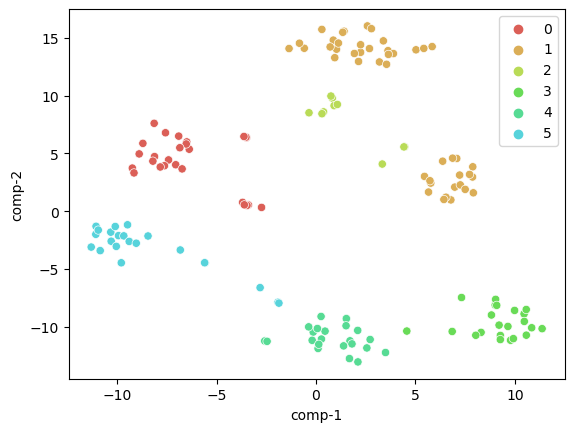

In [131]:
t_sne(X_train, 20, gmm_6)

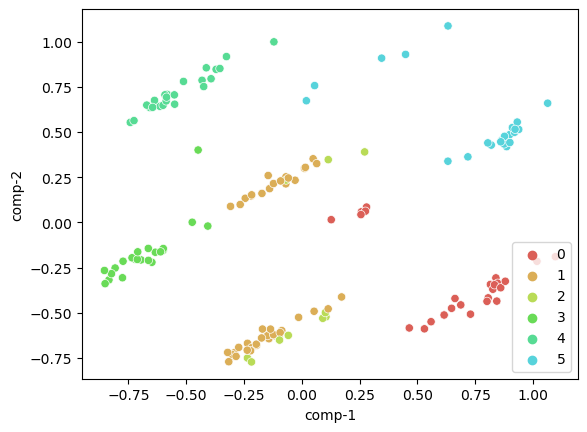

In [132]:
pca_plt(X_train, gmm_6) 

In [167]:
data = {'6 klastrów' : [silhouette_score(X_train, gmm6_rand.predict(X_train)),
                        davies_bouldin_score(X_train, gmm_6), calinski_harabasz_score(X_train, gmm_6)],
        'Lepsza większa czy mniejsza wartość?' : ['większa','mniejsza', 'większa']}

df_gmm = pd.DataFrame(data)
df_gmm.index = ['Silhouette Score','Davies Bouldin Score', 'Calinski Harabasz Score']
df_gmm

,6 klastrów,Lepsza większa czy mniejsza wartość?
Silhouette Score,0.280149,większa
Davies Bouldin Score,1.341845,mniejsza
Calinski Harabasz Score,36.525221,większa



Metryki również wychodzą gorzej niż dla KMeans, jednak GMM grupuje lepiej niż DBSCAN i OPTICS. 
Dla zasady zobaczymy również jak wyglądają wyniki dla danych z kolumnami encodowanymi.

In [139]:
gmm6_rand_enc = GaussianMixture(tol=0.001, n_components=best_params['n_components'], n_init=1, max_iter=best_params['max_iter'], init_params='kmeans', covariance_type='tied')
gmm_6_enc = gmm6_rand_enc.fit_predict(X_train2)

In [168]:
data = {'6 klastrów' : [silhouette_score(X_train, gmm6_rand_enc.predict(X_train2)),
                        davies_bouldin_score(X_train2, gmm_6_enc), calinski_harabasz_score(X_train2, gmm_6_enc)],
        'Lepsza większa czy mniejsza wartość?' : ['większa','mniejsza', 'większa']}

df_gmm = pd.DataFrame(data)
df_gmm.index = ['Silhouette Score','Davies Bouldin Score', 'Calinski Harabasz Score']
df_gmm

,6 klastrów,Lepsza większa czy mniejsza wartość?
Silhouette Score,0.046448,większa
Davies Bouldin Score,1.479488,mniejsza
Calinski Harabasz Score,28.659403,większa


Bez zaskoczenia. Tu metryki są gorsze. Warto zwrócić uwagę, że w tym wypadku Calinski Harabasz ma niewiele mniejszą wartość niż dla lepszego od DBSCAN modelu OPTICS trenowanego na zbiorze bez kolumn encodowanych.

### Agglomerative Clustering

Na koniec zobaczymy grupowanie hierachiczne, zobaczymy najpierw jak poradzi sobie Agglomerative Clustering dla 6 klastrów

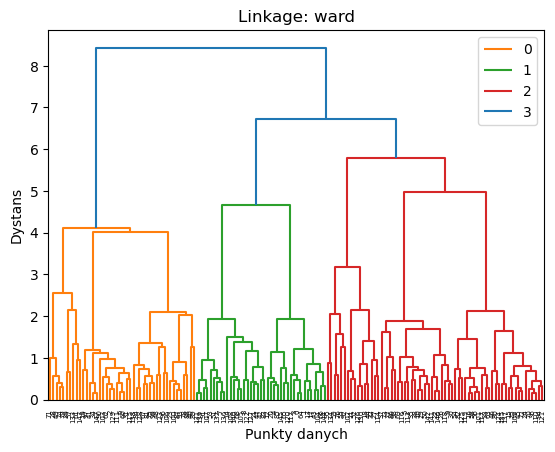

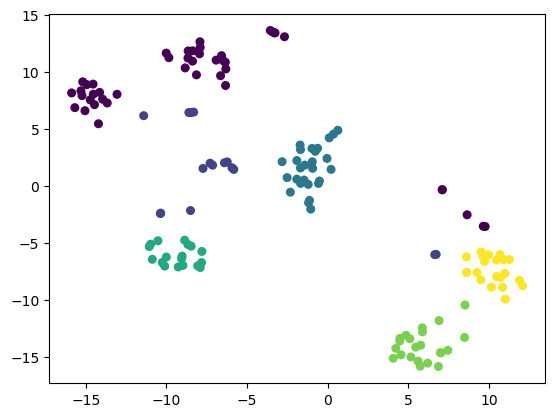

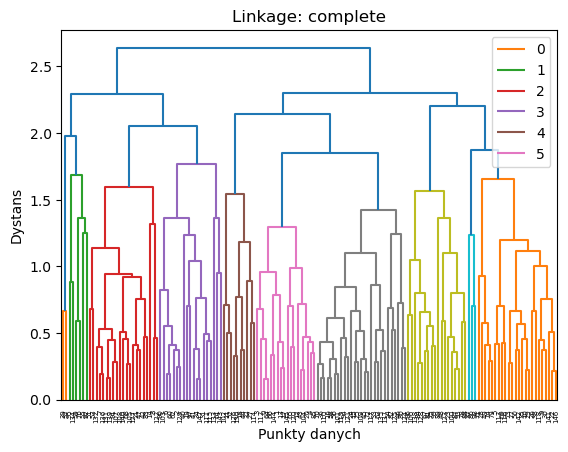

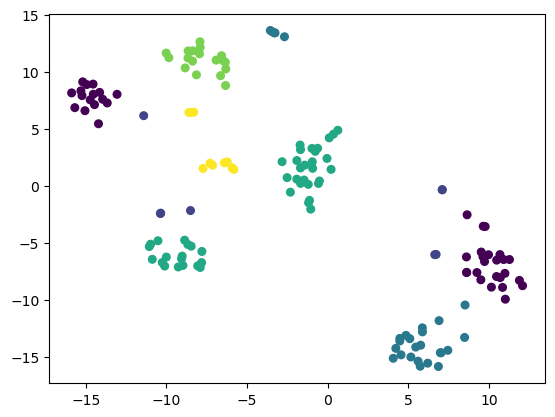

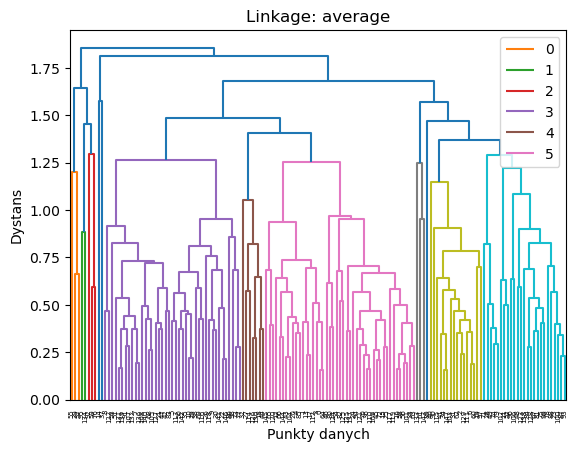

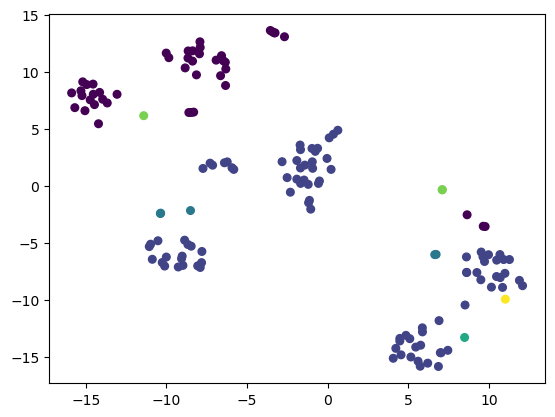

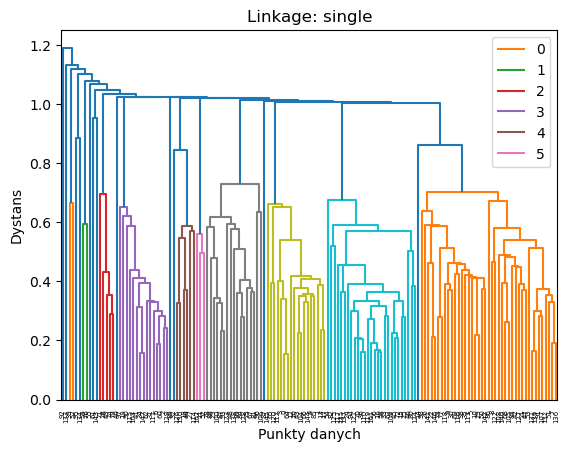

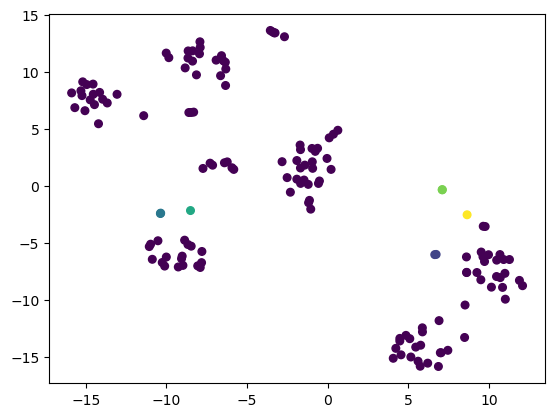

In [58]:
linkage_types = ['ward', 'complete', 'average', 'single']
tsne = TSNE(n_components=2, perplexity=20, learning_rate='auto', init='random').fit_transform(X_train)

#Zobaczmy jak wyglądają dendrogramy dla różnych typów linkage
for linkage_type in linkage_types:
    agg_clustering = AgglomerativeClustering(n_clusters=6, linkage=linkage_type)
    labels = agg_clustering.fit_predict(X_train)
    linkage_matrix = scipy_linkage(X_train, method=linkage_type)
    #Dendrogramy
    dendrogram(linkage_matrix)
    plt.title(f'Linkage: {linkage_type}')
    plt.xlabel('Punkty danych')
    plt.ylabel('Dystans')
    cluster_nums = np.unique(labels)
    legend_labels=[f'{label}' for label in cluster_nums]
    plt.legend(legend_labels)
    plt.show()

    #scatter ploty
    plt.scatter(tsne[:,0], tsne[:,1], c=labels, s=30, cmap='viridis')
    plt.show()

    

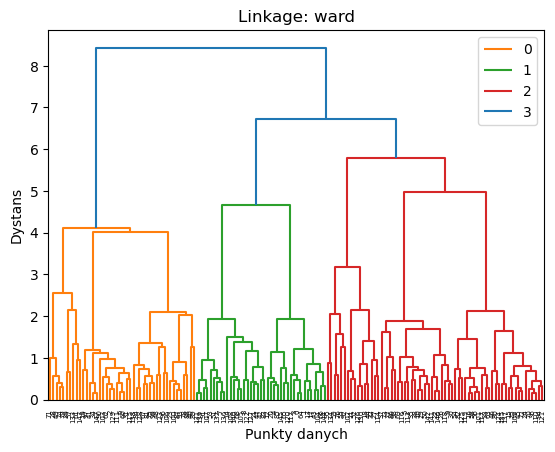

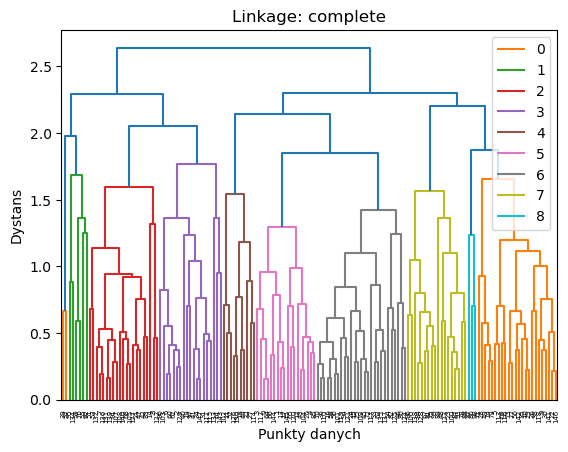

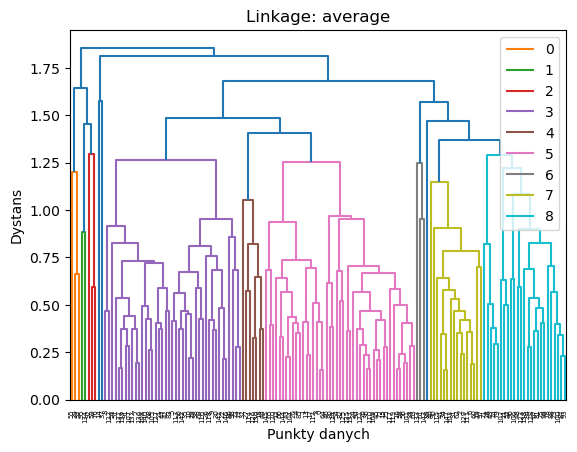

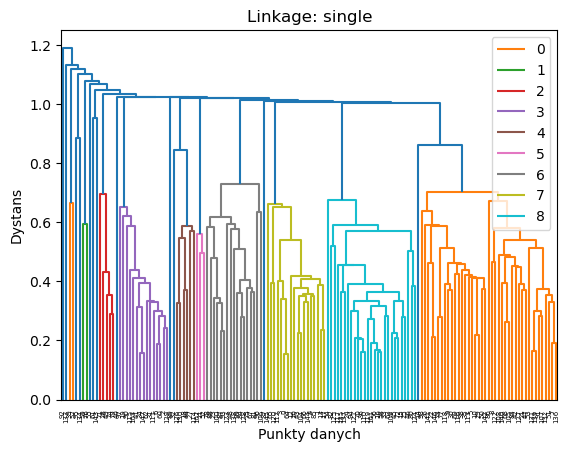

In [45]:
#Zobaczmy jak wyglądają dendrogramy dla 9 klastrów
for linkage_type in linkage_types:
    agg_clustering = AgglomerativeClustering(n_clusters=9, linkage=linkage_type)
    labels = agg_clustering.fit_predict(X_train)
    linkage_matrix = scipy_linkage(X_train, method=linkage_type)
    #Dendrogramy
    dendrogram(linkage_matrix)
    plt.title(f'Linkage: {linkage_type}')
    plt.xlabel('Punkty danych')
    plt.ylabel('Dystans')
    cluster_nums = np.unique(labels)
    legend_labels=[f'{label}' for label in cluster_nums]
    plt.legend(legend_labels)
    plt.show()

Jakaś interpretacja dych dendrogramów? Ja nie mam pomysłu co się tu dzieje ://

Naszym ostatecznym modelem KMeans jest kmeans6.